In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

In [2]:
path = '../cs5228-2310-final-project/'
df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

In [3]:
def from_lat_long_to_dis(latA, lonA, latB, lonB):
    ra = 6378140
    rb = 6356755
    flatten = (ra - rb) / ra

    rad_lat_A = np.radians(latA)
    rad_lng_A = np.radians(lonA)
    rad_lat_B = np.radians(latB)
    rad_lng_B = np.radians(lonB)

    pA = np.arctan(rb / ra * np.tan(rad_lat_A))
    pB = np.arctan(rb / ra * np.tan(rad_lat_B))
    x = np.arccos(np.sin(pA) * np.sin(pB) + np.cos(pA) * np.cos(pB) * np.cos(rad_lng_A - rad_lng_B))
    c1 = (np.sin(x) - x) * (np.sin(pA) + np.sin(pB)) ** 2 / np.cos(x / 2) ** 2
    c2 = (np.sin(x) + x) * (np.sin(pA) - np.sin(pB)) ** 2 / np.sin(x / 2) ** 2
    dr = flatten / 8 * (c1 - c2)
    distance = ra * (x + dr)
    distance /= 1000 # convert to km
    return distance




In [4]:
from_lat_long_to_dis(26.08, 119.28, 24.26, 118.04)# fuzhou to xiamen

237.2152647407692

In [5]:
df_train['rent_approval_date'] = pd.to_datetime(df_train['rent_approval_date'])

In [6]:
dates = pd.to_datetime(df_train['rent_approval_date']).unique()
#select date[0] data
df_train_date = df_train[df_train['rent_approval_date'] == dates[-1]]

In [7]:
df_train_date

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
129,2022-09-01,central,662,buffalo road,4-room,improved,82.0,yes,1982,1.306171,103.850106,0.0,farrer park,rochor,central region,4200
130,2022-09-01,bukit batok,370,bukit batok street 31,4-room,simplified,84.0,yes,1985,1.359984,103.749882,0.0,hong kah north,bukit batok,west region,3800
148,2022-09-01,ang mo kio,326,ang mo kio avenue 3,4-room,new generation,92.0,yes,1977,1.367069,103.847902,0.0,townsville,ang mo kio,north-east region,3450
225,2022-09-01,ang mo kio,610,Ang Mo Kio Avenue 4,3-room,new generation,68.0,yes,1980,1.379395,103.839157,0.0,yio chu kang west,ang mo kio,north-east region,2600
303,2022-09-01,kallang/whampoa,8b,Upper Boon Keng Road,3-room,premium apartment,70.0,yes,2017,1.312344,103.869898,0.0,boon keng,kallang,central region,2950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59698,2022-09-01,bukit panjang,623,Senja Road,5-room,improved,110.0,yes,2001,1.386256,103.762201,0.0,senja,bukit panjang,west region,2750
59769,2022-09-01,geylang,102,Aljunied Crescent,3-room,new generation,82.0,yes,1978,1.320481,103.882473,0.0,aljunied,geylang,central region,2100
59783,2022-09-01,bishan,443,sin ming avenue,4-room,model a,105.0,yes,1990,1.358948,103.832788,0.0,upper thomson,bishan,central region,2050
59862,2022-09-01,jurong east,227,jurong east street 21,5-room,improved,120.0,yes,1984,1.341821,103.736088,0.0,yuhua east,jurong east,west region,2500


In [34]:
##KNN model
from sklearn.neighbors import KNeighborsRegressor

# train
X_train = df_train_date[['latitude', 'longitude']]
y_train = df_train_date['monthly_rent']

# fit
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train, y_train)

# draw fitted surface
# create meshgrid
x_min, x_max = X_train['latitude'].min(), X_train['latitude'].max()
y_min, y_max = X_train['longitude'].min(), X_train['longitude'].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# predict
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)



c:\ProgramData\anaconda3\envs\CS5228\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



In [35]:
#draw 3D surface
from plotly import graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure(data=[go.Surface(z=Z, x=xx, y=yy)])

fig.update_layout(title='KNN Surface', autosize=False,
                    width=500, height=500,
                    margin=dict(l=65, r=50, b=65, t=90))

#mark the position of NUS
fig.add_trace(go.Scatter3d(x=[1.29595], y=[103.77525], z=[Z.max()], mode='markers', marker=dict(size=5, color='red')))
#mark the position of NTU
fig.add_trace(go.Scatter3d(x=[1.3483], y=[103.68469], z=[Z.max()], mode='markers', marker=dict(size=5, color='red')))

fig.show()


In [44]:
df_train_date['distance_to_NUS'] = from_lat_long_to_dis(df_train_date['latitude'], df_train_date['longitude'], 1.29595, 103.77525)
df_train_date['distance_to_NTU'] = from_lat_long_to_dis(df_train_date['latitude'], df_train_date['longitude'], 1.3483, 103.68469)

C:\Users\Concyclics\AppData\Local\Temp\ipykernel_31016\64479518.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Concyclics\AppData\Local\Temp\ipykernel_31016\64479518.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
df_train_date

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent,distance_to_NUS,distance_to_NTU
129,2022-09-01,central,662,buffalo road,4-room,improved,82.0,yes,1982,1.306171,103.850106,0.0,farrer park,rochor,central region,4200,8.407163,18.989427
130,2022-09-01,bukit batok,370,bukit batok street 31,4-room,simplified,84.0,yes,1985,1.359984,103.749882,0.0,hong kah north,bukit batok,west region,3800,7.622636,7.369274
148,2022-09-01,ang mo kio,326,ang mo kio avenue 3,4-room,new generation,92.0,yes,1977,1.367069,103.847902,0.0,townsville,ang mo kio,north-east region,3450,11.279062,18.281859
225,2022-09-01,ang mo kio,610,Ang Mo Kio Avenue 4,3-room,new generation,68.0,yes,1980,1.379395,103.839157,0.0,yio chu kang west,ang mo kio,north-east region,2600,11.649829,17.530859
303,2022-09-01,kallang/whampoa,8b,Upper Boon Keng Road,3-room,premium apartment,70.0,yes,2017,1.312344,103.869898,0.0,boon keng,kallang,central region,2950,10.688348,20.991719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59698,2022-09-01,bukit panjang,623,Senja Road,5-room,improved,110.0,yes,2001,1.386256,103.762201,0.0,senja,bukit panjang,west region,2750,10.090630,9.592912
59769,2022-09-01,geylang,102,Aljunied Crescent,3-room,new generation,82.0,yes,1978,1.320481,103.882473,0.0,aljunied,geylang,central region,2100,12.237314,22.225068
59783,2022-09-01,bishan,443,sin ming avenue,4-room,model a,105.0,yes,1990,1.358948,103.832788,0.0,upper thomson,bishan,central region,2050,9.461946,16.523598
59862,2022-09-01,jurong east,227,jurong east street 21,5-room,improved,120.0,yes,1984,1.341821,103.736088,0.0,yuhua east,jurong east,west region,2500,6.687446,5.764707


In [ ]:
df_train_date['distance_to_NUS in 500m'] = df_train_date['distance_to_NUS'].apply(lambda x: 1 if x <= 0.5 else 0)

<Axes: xlabel='distance_to_NTU', ylabel='monthly_rent'>

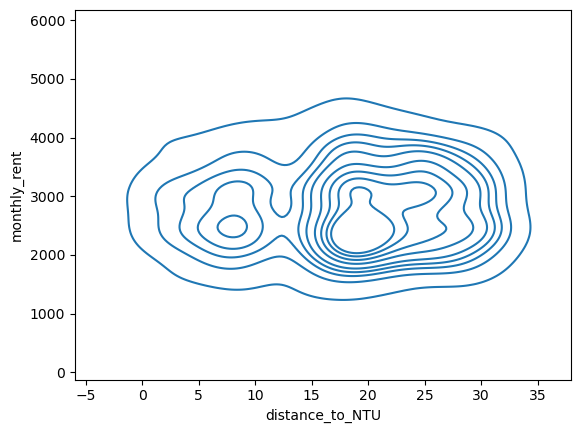

In [47]:
#draw distance to NUS with monthly rent
sns.kdeplot(x = "distance_to_NTU", y = "monthly_rent", data = df_train_date)